In [1]:
import sys
import os
import glob
import h5py

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")

import paper_plot as pp

plot = pp.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
from scipy.interpolate import griddata

import ROOT
from ROOT import TLorentzVector, TVector3

import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [2]:
def load_particles_from_h5(filename="/root/data/mc20_truth.h5"):
    result = {}

    with h5py.File(filename, "r") as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}

            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]

            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value

            result[group_name] = group_data

    return result

In [3]:
# main algorithm

def cglmp(z_xp, z_xn, z_yp, z_yn):
    """
    This is a function to calculate Bij (CGLMP values).
    :param z_xp: Angle (xi) between positive lepton and x-axis.
    :param z_xn: Angle (xi) between negative lepton and x-axis.
    :param z_yp: Angle (xi) between positive lepton and y-axis.
    :param z_xn: Angle (xi) between negative lepton and y-axis.
    """
    # count expectation value, use (27) in Alan's paper
    tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
    tr_b = (
        25 * (np.square(z_xp) - np.square(z_yp)) * (np.square(z_xn) - np.square(z_yn))
    )
    tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
    tr = tr_a + tr_b + tr_c

    return tr


def main_alg(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 5.1 Calculate GGM
    # GGM
    lp_pt = np.sqrt(
        np.square(WpLp_k.X()) + np.square(WpLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    ln_pt = np.sqrt(
        np.square(WnLp_k.X()) + np.square(WnLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    lp_phi = np.arctan2(WpLp_k.Y(), WpLp_k.X())  # phi = arctan(Py/Px)
    ln_phi = np.arctan2(WnLp_k.Y(), WnLp_k.X())  # phi = arctan(Py/Px)
    lp_theta = np.arctan(np.divide(lp_pt, WpLp_k.Z()))  # theta = arctan(PT/Pz)
    ln_theta = np.arctan(np.divide(ln_pt, WnLp_k.Z()))  # theta = arctan(PT/Pz)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        np.array([lp_pt, lp_phi, lp_theta]),
        np.array([ln_pt, ln_phi, ln_theta]),
    )

# declare a generator for the resuts

def result_generator(particles):
    bij = np.zeros((particles.shape[0], 3))
    xi_lead = np.zeros((particles.shape[0], 3))
    xi_sublead = np.zeros((particles.shape[0], 3))
    ggm_lead = np.zeros((particles.shape[0], 3))
    ggm_sublead = np.zeros((particles.shape[0], 3))
    result = np.array((particles.shape[0], 3, 5))
    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(main_alg, particles)))
    bij = result[:, 0]
    xi_lead = result[:, 1]
    xi_sublead = result[:, 2]
    ggm_lead = result[:, 3]
    ggm_sublead = result[:, 4]
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_lead[~mask, :],
        xi_sublead[~mask, :],
        ggm_lead[~mask, :],
        ggm_sublead[~mask, :],
        mask,
    )
    
# 8 Wigner P-symbols angular functions

def P1(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.cos(phi)


def P2(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.sin(phi)


def P3(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 0.25 * (c * 4 * np.cos(theta) + 15 * np.cos(2 * theta) + 5)


def P4(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.cos(2 * phi)


def P5(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.sin(2 * phi)


def P6(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.cos(phi)


def P7(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.sin(phi)


def P8(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(1 / 48) * (c * 12 * np.cos(theta) - 15 * np.cos(2 * theta) - 5)

def compute_Wigner(Phi_func: callable, angles: tuple, sign: str) -> np.float64:
    """
    Compute Wigner function for given angles and sign.
    """
    theta_0toPi, phi_0to2Pi = angles
    return Phi_func(theta_0toPi, phi_0to2Pi, sign)


def C_matrix(lp_theta, lp_phi, ln_theta, ln_phi):
    # Adjust angles to the paper requiring
    lp_theta_0toPi = np.where(lp_theta < 0, np.pi + lp_theta, lp_theta)
    ln_theta_0toPi = np.where(ln_theta < 0, np.pi + ln_theta, ln_theta)
    lp_phi_0to2Pi = np.where(lp_phi < 0, 2 * np.pi + lp_phi, lp_phi)
    ln_phi_0to2Pi = np.where(ln_phi < 0, 2 * np.pi + ln_phi, ln_phi)

    PSymb = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
    Phi_functions = [P1, P2, P3, P4, P5, P6, P7, P8]

    # Compute Wigner functions
    WignerPp_results = [
        compute_Wigner(Phi, (lp_theta_0toPi, lp_phi_0to2Pi), "pos")
        for Phi in Phi_functions
    ]
    WignerPn_results = [
        compute_Wigner(Phi, (ln_theta_0toPi, ln_phi_0to2Pi), "neg")
        for Phi in Phi_functions
    ]

    # Construct DataFrames from results
    WignerPp = pd.DataFrame(
        {PSymb[i] + "+": result for i, result in enumerate(WignerPp_results)}
    )
    WignerPn = pd.DataFrame(
        {PSymb[i] + "-": result for i, result in enumerate(WignerPn_results)}
    )

    # Compute C matrix using vectorized operations
    C = np.zeros((9, 9))
    C[0, 1:] = WignerPp.mean() * 0.5
    C[1:, 0] = WignerPn.mean() * 0.5
    for i in range(8):
        for j in range(8):
            C[i + 1, j + 1] = np.mean(WignerPn.iloc[:, i] * WignerPp.iloc[:, j]) * 0.25

    return C, WignerPp, WignerPn, lp_phi_0to2Pi, ln_phi_0to2Pi, lp_theta_0toPi, ln_theta_0toPi, 

In [4]:
# plotting functions

def ggm_plot(C):
    # Input validation
    if not isinstance(C, np.ndarray) or C.shape != (9, 9):
        raise ValueError("Input matrix C must be a 9x9 NumPy array")

    # Create figure
    with plt.style.context('seaborn-v0_8-whitegrid'):
        fig, ax = plt.subplots(figsize=(7, 7), dpi=120)
        
        # Generate meshgrid
        xx, yy = np.meshgrid(np.arange(9), np.arange(9))
        
        # Plot heatmap
        im = ax.pcolormesh(
            xx,
            yy,
            C,
            cmap='RdBu_r',
            vmin=-0.25,
            vmax=0.25,
            shading='nearest',
            edgecolors='none',
        )
        
        # Set aspect ratio and limits
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, 8.5)
        ax.set_ylim(-0.5, 8.5)
        
        # Customize axes
        ax.set_xticks(np.arange(9))
        ax.set_yticks(np.arange(9))
        ax.set_xlabel(r"$W^{\ell_0}$ GM index", fontsize=18)
        ax.set_ylabel(r"$W^{\ell_1}$ GM index", fontsize=18)
        
        # Improve tick appearance
        ax.tick_params(
            axis='both',
            which='both',
            length=0,
            labelsize=16
        )
        
        # Enhanced colorbar matched to y-axis height
        cbar = fig.colorbar(
            im,
            ax=ax,
            orientation='vertical',
            pad=0.02,
            fraction=0.0467,  # Proportion of original axes (tuned for size match)
            aspect=20,       # Aspect ratio (adjusted to match y-axis)
        )
        
        # Customize colorbar ticks
        ticks = np.linspace(-0.25, 0.25, 11)
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])
        cbar.ax.tick_params(labelsize=16)
        
        # Add zero line
        cbar.ax.axhline(y=0, color='grey', linestyle='-', linewidth=1, alpha=0.6)
        
        # Optional grid lines
        ax.grid(True, which='major', linestyle='--', alpha=1)
        
        # Optimize layout and display
        plt.tight_layout()
        plt.show()
        plt.close(fig)

def p_plot(theta, phi, p_sym, mode="pos"):
    # Set up the figure with 2x4 subplots (2 rows, 4 columns)
    fig = plt.figure(figsize=(36, 18), dpi=200)
    
    # Adjust subplot parameters to increase spacing between columns
    plt.subplots_adjust(wspace=1.0)
    plt.subplots_adjust(hspace=2.0)

    # List of all p_sym columns to plot
    if mode == "pos":
        columns = ['P1+', 'P2+', 'P3+', 'P4+', 'P5+', 'P6+', 'P7+', 'P8+']
        name = [r'$\Phi^{P_+}_{1}$', r'$\Phi^{P_+}_{2}$', r'$\Phi^{P_+}_{3}$', r'$\Phi^{P_+}_{4}$', r'$\Phi^{P_+}_{5}$', r'$\Phi^{P_+}_{6}$', r'$\Phi^{P_+}_{7}$', r'$\Phi^{P_+}_{8}$']
    elif mode =="neg":
        columns = ['P1-', 'P2-', 'P3-', 'P4-', 'P5-', 'P6-', 'P7-', 'P8-']
        name = [r'$\Phi^{P_-}_{1}$', r'$\Phi^{P_-}_{2}$', r'$\Phi^{P_-}_{3}$', r'$\Phi^{P_-}_{4}$', r'$\Phi^{P_-}_{5}$', r'$\Phi^{P_-}_{6}$', r'$\Phi^{P_-}_{7}$', r'$\Phi^{P_-}_{8}$']
    else:
        raise ValueError("Invalid mode. Choose 'pos' or 'neg'.")

    # Set up the grid for interpolation with fixed ranges
    xi = np.linspace(0, np.pi, 201)  # Fixed theta range from 0 to pi
    yi = np.linspace(0, 2*np.pi, 201)  # Fixed phi range from 0 to 2pi
    X, Y = np.meshgrid(xi, yi)

    # Calculate global min and max for consistent color normalization
    all_Z_values = []
    for col in columns:
        Z = griddata((theta, phi), p_sym[col], (X, Y), method='linear')
        all_Z_values.append(Z)

    # Find global min and max across all plots, ignoring NaN values
    global_min = np.nanmin([np.nanmin(z) for z in all_Z_values])
    global_max = np.nanmax([np.nanmax(z) for z in all_Z_values])
    norm = Normalize(vmin=global_min, vmax=global_max)

    # Create subplots
    for i, col in enumerate(columns):
        # Calculate position (4 columns, 2 rows)
        row = i // 4
        col_pos = i % 4
        
        # Create 3D subplot
        ax = fig.add_subplot(2, 4, i+1, projection='3d')
        
        # Use the pre-calculated Z values
        Z = all_Z_values[i]
        
        # Create the 3D surface plot with consistent color normalization
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', 
                            alpha=0.95, norm=norm)
        
        # Set labels (keep only axis labels)
        ax.set_xlabel(r'$\theta$', fontsize=38, labelpad=20)
        ax.set_ylabel(r'$\phi$', fontsize=38, labelpad=20)
        ax.set_title(name[i], fontsize=38, pad=-50)
        
        # Set fixed axis limits
        ax.set_xlim(np.pi, 0)  # Flipped theta axis (π to 0)
        ax.set_ylim(0, 2*np.pi)  # Fixed phi axis (0 to 2π)
        
        # Set consistent view angle
        ax.view_init(elev=30, azim=30)

    plt.tight_layout()
    plt.show()

In [5]:
mc20_data = load_particles_from_h5()
mc20_data.keys()

dict_keys(['higgs', 'lead_w', 'sublead_w', 'truth_dilep', 'truth_dilep_car', 'truth_lead_lep', 'truth_lead_lep_car', 'truth_lead_nu', 'truth_lead_nu_car', 'truth_sublead_lep', 'truth_sublead_lep_car', 'truth_sublead_nu', 'truth_sublead_nu_car'])

In [6]:
# original truth
truth_lead_lep = mc20_data["truth_lead_lep"]
truth_sublead_lep = mc20_data["truth_sublead_lep"]
truth_lead_nu = mc20_data["truth_lead_nu"]
truth_sublead_nu = mc20_data["truth_sublead_nu"]
truth_lead_lep_p4 = mc20_data["truth_lead_lep"]["p4"]
truth_sublead_lep_p4 = mc20_data["truth_sublead_lep"]["p4"]
truth_lead_nu_p4 = mc20_data["truth_lead_nu"]["p4"]
truth_sublead_nu_p4 = mc20_data["truth_sublead_nu"]["p4"]
truth_met_pt = np.sqrt(np.square((truth_lead_nu_p4 + truth_sublead_nu_p4)[...,0:2]).sum(axis=-1))

# CAR truth
truth_lead_lep_car = mc20_data["truth_lead_lep_car"]
truth_sublead_lep_car = mc20_data["truth_sublead_lep_car"]
truth_lead_nu_car = mc20_data["truth_lead_nu_car"]
truth_sublead_nu_car = mc20_data["truth_sublead_nu_car"]
truth_lead_lep_car_p4 = mc20_data["truth_lead_lep_car"]["p4"]
truth_sublead_lep_car_p4 = mc20_data["truth_sublead_lep_car"]["p4"]
truth_lead_nu_car_p4 = mc20_data["truth_lead_nu_car"]["p4"]
truth_sublead_nu_car_p4 = mc20_data["truth_sublead_nu_car"]["p4"]
truth_met_pt_car = np.sqrt(np.square((truth_lead_nu_car_p4 + truth_sublead_nu_car_p4)[...,0:2]).sum(axis=-1))

# W bosons
w_lead_p4 = mc20_data["lead_w"]["p4"]
w_sublead_p4 = mc20_data["sublead_w"]["p4"]

In [7]:
###############################################
# Truth sudy --> do not use cut at beginning! #
###############################################

print("Truth: pre-cut")
cut_pre_pt_lead = truth_lead_lep["pt"] > -999
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep["pt"] > -999
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"])
    - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"])
    - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"])
    - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"])
    > -999
)
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt > -999
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(truth_lead_lep["energy"]) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)
print(f'''
Check minimum and maximum cuts for each variables:
- pt_lead: {np.min(truth_lead_lep["pt"])}, {np.max(truth_lead_lep["pt"])}
- pt_sublead: {np.min(truth_sublead_lep["pt"])}, {np.max(truth_sublead_lep["pt"])}
- dilep_m: {np.min(np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"]) - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"]) - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"]) - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"]))}, {np.max(np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"]) - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"]) - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"]) - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"]))}
- pt_miss: {np.min(truth_met_pt)}, {np.max(truth_met_pt)}
- eta_lead: {np.min(np.abs(truth_lead_lep["eta"]))}, {np.max(np.abs(truth_lead_lep["eta"]))}
- eta_sublead: {np.min(np.abs(truth_sublead_lep["eta"]))}, {np.max(np.abs(truth_sublead_lep["eta"]))}
- phi_lead: {np.min(np.abs(truth_lead_lep["phi"]))}, {np.max(np.abs(truth_lead_lep["phi"]))}
- phi_sublead: {np.min(np.abs(truth_sublead_lep["phi"]))}, {np.max(np.abs(truth_sublead_lep["phi"]))}
''')

# CAR
print("CAR: pre-cut")
cut_pre_pt_lead = truth_lead_lep_car["pt"] > -999
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep_car["pt"] > -999
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep_car["energy"] + truth_sublead_lep_car["energy"])
    - np.square(truth_lead_lep_car["px"] + truth_sublead_lep_car["px"])
    - np.square(truth_lead_lep_car["py"] + truth_sublead_lep_car["py"])
    - np.square(truth_lead_lep_car["pz"] + truth_sublead_lep_car["pz"])
    > -999
)
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt_car > -999
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT_CAR = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(truth_lead_lep_car["energy"]) - np.sum(PRE_CUT_CAR * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)
print(f'''
Check minimum cuts for each variables:
- pt_lead: {np.min(truth_lead_lep_car["pt"])}, {np.max(truth_lead_lep_car["pt"])}
- pt_sublead: {np.min(truth_sublead_lep_car["pt"])}, {np.max(truth_sublead_lep_car["pt"])}
- dilep_m: {np.min(np.square(truth_lead_lep_car["energy"] + truth_sublead_lep_car["energy"]) - np.square(truth_lead_lep_car["px"] + truth_sublead_lep_car["px"]) - np.square(truth_lead_lep_car["py"] + truth_sublead_lep_car["py"]) - np.square(truth_lead_lep_car["pz"] + truth_sublead_lep_car["pz"]))}, {np.max(np.square(truth_lead_lep_car["energy"] + truth_sublead_lep_car["energy"]) - np.square(truth_lead_lep_car["px"] + truth_sublead_lep_car["px"]) - np.square(truth_lead_lep_car["py"] + truth_sublead_lep_car["py"]) - np.square(truth_lead_lep_car["pz"] + truth_sublead_lep_car["pz"]))}
- pt_miss: {np.min(truth_met_pt_car)}, {np.max(truth_met_pt_car)}
- eta_lead: {np.min(np.abs(truth_lead_lep_car["eta"]))}, {np.max(np.abs(truth_lead_lep_car["eta"]))}
- eta_sublead: {np.min(np.abs(truth_sublead_lep_car["eta"]))}, {np.max(np.abs(truth_sublead_lep_car["eta"]))}
- phi_lead: {np.min(np.abs(truth_lead_lep_car["phi"]))}, {np.max(np.abs(truth_lead_lep_car["phi"]))}
- phi_sublead: {np.min(np.abs(truth_sublead_lep_car["phi"]))}, {np.max(np.abs(truth_sublead_lep_car["phi"]))}
''')

Truth: pre-cut
0
0
0
0
0

Check minimum and maximum cuts for each variables:
- pt_lead: 2.6344006061553955, 903.0465698242188
- pt_sublead: 0.10892227292060852, 456.6785888671875
- dilep_m: -0.125, 13073.033203125
- pt_miss: 0.04840080653315385, 1051.9500355657528
- eta_lead: 1.4988905832069577e-06, 5.197643280029297
- eta_sublead: 7.403316431009443e-07, 7.951803684234619
- phi_lead: 4.27651139034424e-06, 3.141592502593994
- phi_sublead: 1.9756910205614986e-06, 3.141591787338257

CAR: pre-cut
0
0
0
0
0

Check minimum cuts for each variables:
- pt_lead: 0.8356871008872986, 804.0167236328125
- pt_sublead: 0.013572425581514835, 385.354736328125
- dilep_m: -0.125, 13130.26953125
- pt_miss: 0.012965580367230639, 1198.0027683873634
- eta_lead: 4.886095439360361e-07, 6.901760101318359
- eta_sublead: 2.5474707854300505e-06, 9.691062927246094
- phi_lead: 7.733814868515765e-07, 3.141592025756836
- phi_sublead: 5.024141387366399e-07, 3.1415905952453613



In [8]:
# calculate results

# original truth
truth_particles = np.concatenate(
    [w_lead_p4[PRE_CUT], truth_lead_lep_p4[PRE_CUT], w_sublead_p4[PRE_CUT], truth_sublead_lep_p4[PRE_CUT]], axis=1
)
truth_bij, truth_xi_pos, truth_xi_neg, truth_ggm_pos, truth_ggm_neg, truth_mask = result_generator(
    truth_particles
)

# CAR truth
car_particles = np.concatenate(
    [w_lead_p4[PRE_CUT_CAR], truth_lead_lep_car_p4[PRE_CUT_CAR], w_sublead_p4[PRE_CUT_CAR], truth_sublead_lep_car_p4[PRE_CUT_CAR]], axis=1
)
car_bij, car_xi_pos, car_xi_neg, car_ggm_pos, car_ggm_neg, car_mask = result_generator(
    car_particles
)

In [9]:
# retrieve elements from P-symbol Phi functions

# original truth
truth_phi_pos, truth_phi_neg = truth_ggm_pos[:, 1], truth_ggm_neg[:, 1]
truth_theta_pos, truth_theta_neg = truth_ggm_pos[:, 2], truth_ggm_neg[:, 2]
# calculate C matrix and Wigner P-symbol functions
truth_C, p_pos, p_neg, phi_pos, phi_neg, theta_pos, theta_neg = C_matrix(truth_theta_pos, truth_phi_pos, truth_theta_neg, truth_phi_neg)

# CAR truth
car_phi_pos, car_phi_neg = car_ggm_pos[:, 1], car_ggm_neg[:, 1]
car_theta_pos, car_theta_neg = car_ggm_pos[:, 2], car_ggm_neg[:, 2]
# calculate C matrix and Wigner P-symbol functions
car_C, car_p_pos, car_p_neg, car_phi_pos, car_phi_neg, car_theta_pos, car_theta_neg = C_matrix(car_theta_pos, car_phi_pos, car_theta_neg, car_phi_neg)

In [ ]:
# original truth GGM plot
# p_plot(theta_pos, phi_pos, p_pos, mode="pos")
# p_plot(theta_neg, phi_neg, p_neg, mode="neg")
ggm_plot(truth_C)

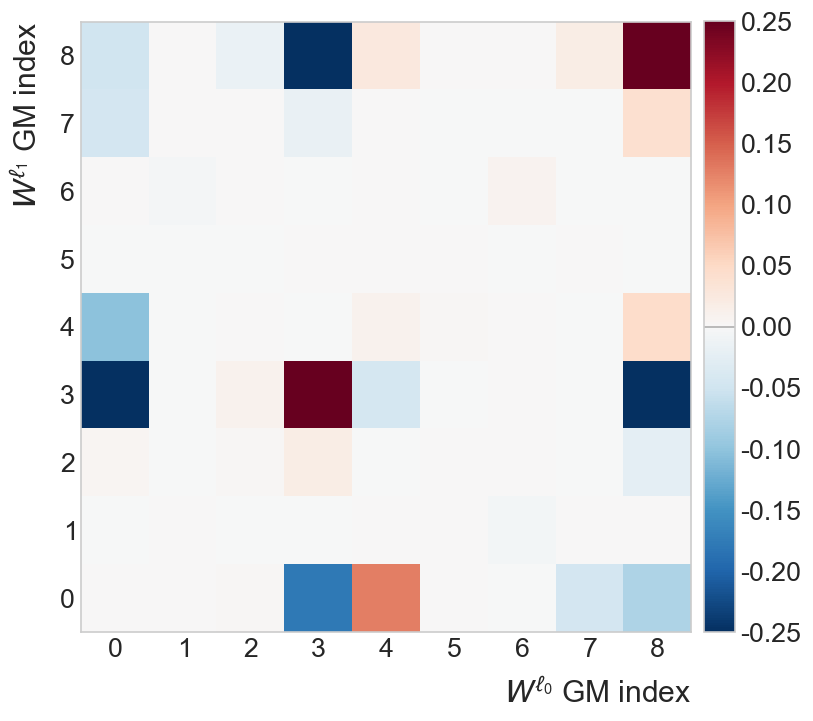

In [11]:
# car truth GGM plot
ggm_plot(car_C)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.gridspec as gridspec
from scipy import stats


def hist_1d3plot(
    true_list_1d,
    pred_list_1d,
    ranges=(-1, 1),
    xlabel="X",
    title="",
    row1_ylabel="Counts",
    row1_legend=["Separable", "SM"],
    bins=50,
    log=True,
    xpad=10,
    weights=None,
    save_name=None,
    dpi=300,
):
    """
    Plot a 1×3 grid with 1D histograms and ratio plots.
    """
    if not isinstance(ranges, list):
        ranges = [ranges] * 3
    if not isinstance(xlabel, list):
        xlabel = [xlabel] * 3
    if not isinstance(title, list):
        title = [title] * 3

    label_size = 18
    tick_size = 14
    title_size = 18

    # Change figure size to be wider than tall since we only have one row
    fig = plt.figure(figsize=(18, 8))
    
    # Create a single row grid with 3 columns
    gs = gridspec.GridSpec(1, 3, wspace=0.2)

    # Create histogram plots with ratio subplots
    first_row_axes = []
    for col in range(3):
        inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=gs[0, col], height_ratios=[6, 2], hspace=0.08
        )
        ax1 = fig.add_subplot(inner_gs[0])
        ax2 = fig.add_subplot(inner_gs[1], sharex=ax1)
        first_row_axes.append((ax1, ax2))
        ax1.tick_params(labelbottom=False)

    # Plot 1D histograms
    for i, (ax1, ax2) in enumerate(first_row_axes):
        if i >= len(true_list_1d) or i >= len(pred_list_1d):
            continue
        
        formatter = plt.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-1, 1))
        ax1.yaxis.set_major_formatter(formatter)

        tr_bar, tr_bin = np.histogram(true_list_1d[i], bins=bins, range=ranges[i], weights=weights)
        pr_bar, _ = np.histogram(pred_list_1d[i], bins=bins, range=ranges[i], weights=weights)

        hep.histplot(tr_bar, tr_bin, ax=ax1, lw=2, color="b", label=row1_legend[1])
        hep.histplot(pr_bar, tr_bin, ax=ax1, lw=2, color="r", label=row1_legend[0])
        ax1.set_xlim(ranges[i])

        diff = np.array(pred_list_1d[i]) - np.array(true_list_1d[i])
        rmse = np.sqrt(np.mean(diff**2))
        sem = stats.sem(diff)
        ax1.set_title(f"{title[i]} (RMSE={rmse:.2f} ± {sem:.2f})", fontsize=title_size, loc="right")
        ax1.legend(fontsize=tick_size)

        if i == 0:
            ax1.set_ylabel(row1_ylabel, fontsize=label_size)
        else:
            ax1.set_ylabel("")
            ax1.tick_params(labelleft=True)

        ratio = np.divide(pr_bar + 1, tr_bar + 1, where=(tr_bar != 0))
        ax2.vlines(tr_bin[1:], 1, ratio, color="k", lw=1)
        for j, val in enumerate(ratio):
            if val > 2:
                ax2.annotate(
                    "", xy=(tr_bin[j + 1], 2), xytext=(tr_bin[j + 1], 1.95),
                    arrowprops=dict(facecolor="k", shrink=0.05, width=1, headwidth=2),
                )
            elif val < 0:
                ax2.annotate(
                    "", xy=(tr_bin[j + 1], 0), xytext=(tr_bin[j + 1], 0.05),
                    arrowprops=dict(facecolor="k", shrink=0.05, width=1, headwidth=2),
                )
            else:
                ax2.scatter(tr_bin[j + 1], val, color="k", lw=1, s=10)

        ax2.set_ylim([0, 2])
        ax2.axhline(1, c="grey", ls="dashed", alpha=0.8)
        ax2.set_xlabel(xlabel[i], fontsize=label_size, labelpad=xpad)

        if i == 0:
            ax2.set_ylabel(f"{row1_legend[0]}/{row1_legend[1]}", fontsize=label_size, loc="center", labelpad=10)
        else:
            ax2.set_ylabel("")
            ax2.tick_params(labelleft=True)

        ax1.tick_params(axis="both", labelsize=tick_size)
        ax2.tick_params(axis="both", labelsize=tick_size, pad=10)

    plt.subplots_adjust(left=0.08, right=0.96, top=0.92, bottom=0.12, wspace=0.15)

    if save_name:
        plt.savefig(f"{save_name}.png", dpi=dpi, bbox_inches="tight")
        print(f"Saved 1D histograms as {save_name}.png")

    plt.show()
    plt.close()

CAR (ground truth) vs SM (ground truth)


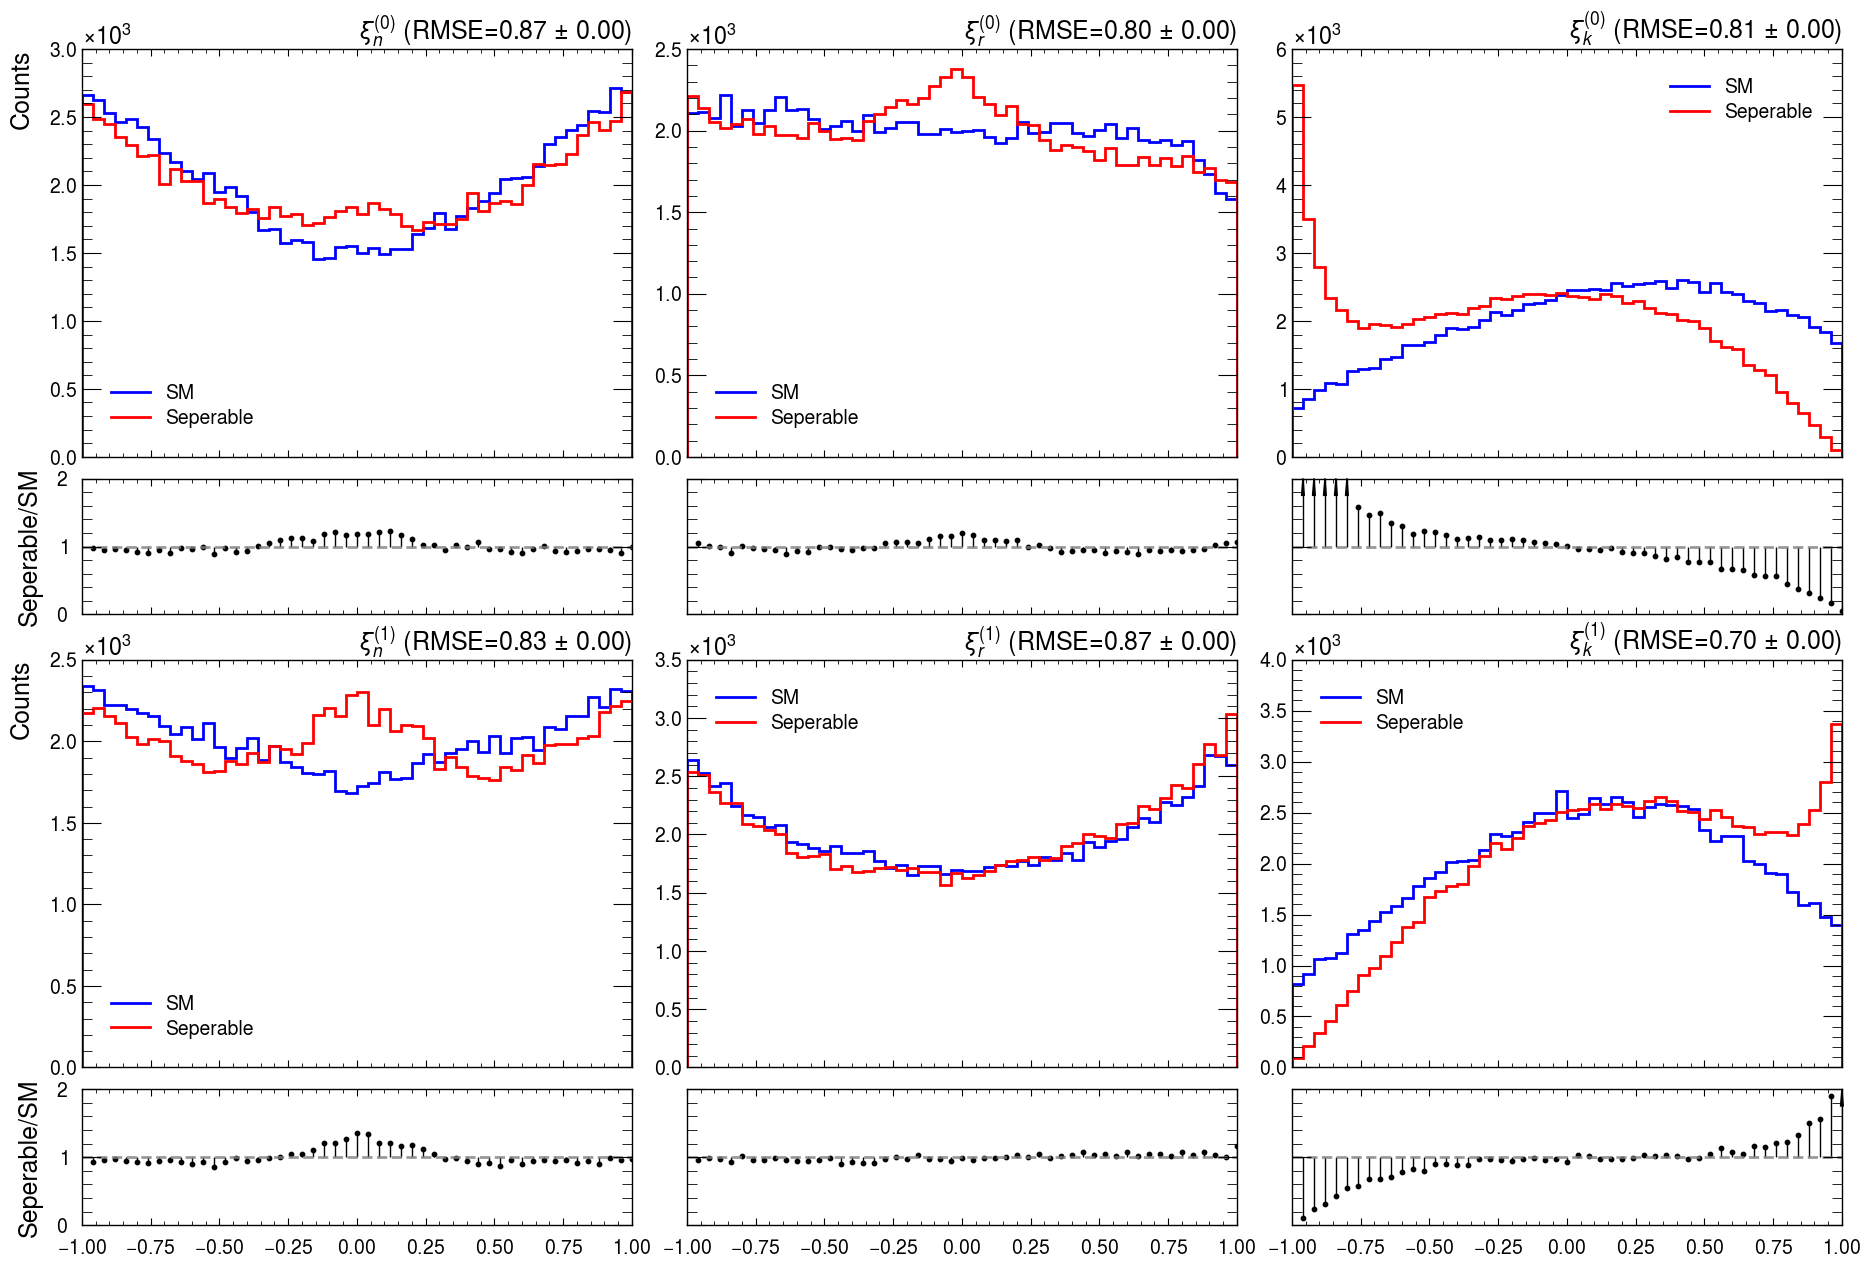

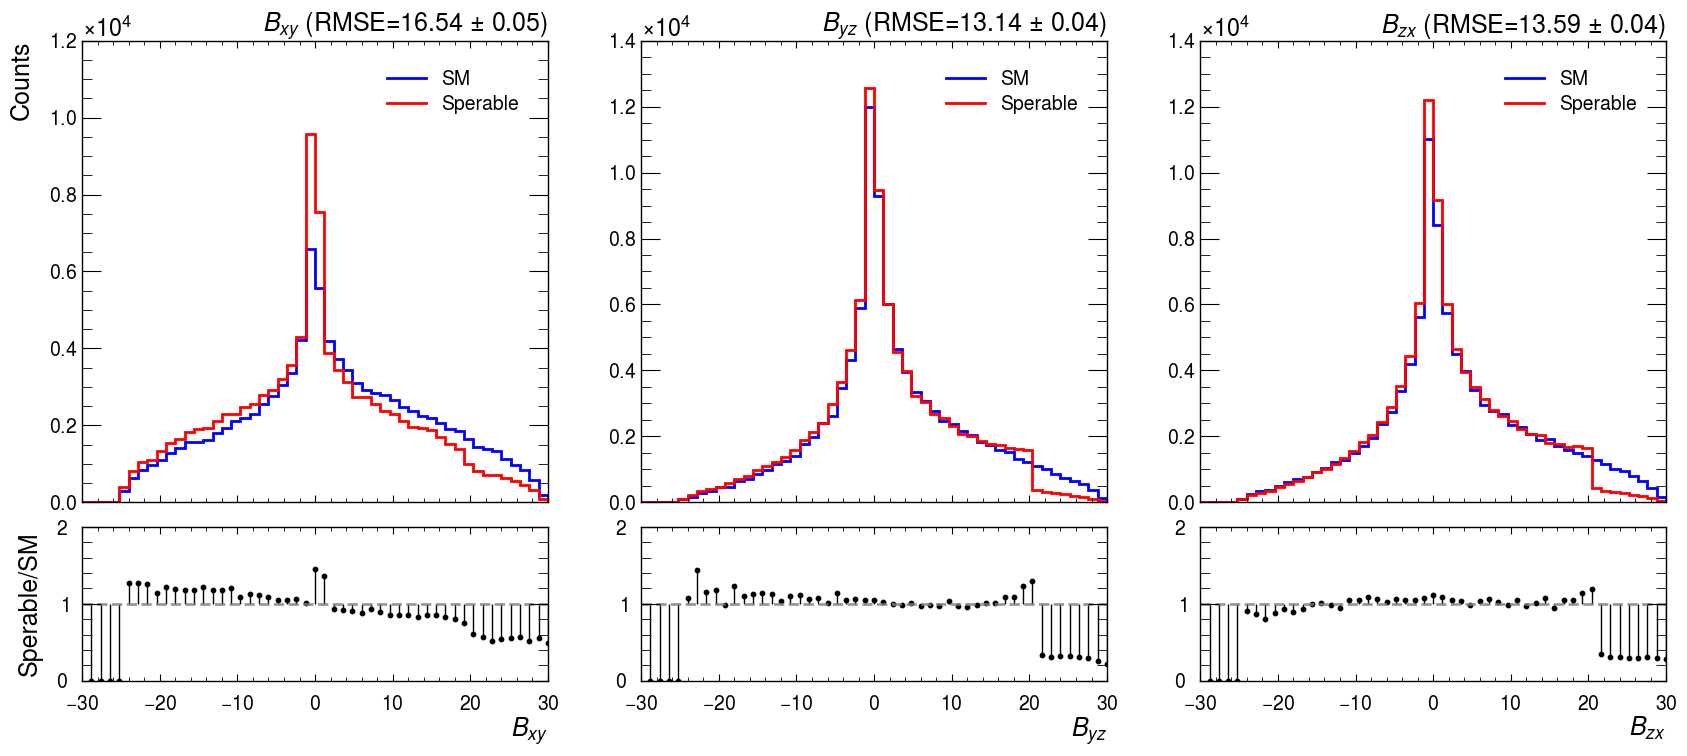


Bxy -> EMD:2.153, kl: 0.628 with SM mean:2.205, Sep mean 0.052
Byz -> EMD:0.968, kl: 0.536 with SM mean:2.494, Sep mean 1.527
Bzx -> EMD:0.977, kl: 0.635 with SM mean:2.771, Sep mean 1.866



In [13]:
"""
Xi comparison:

CAR (ground truth) vs SM (ground truth)
"""

print("CAR (ground truth) vs SM (ground truth)")
length_selected = 100_000

# xi
xi_plot_true = [
    truth_xi_pos[:, 0][:length_selected],
    truth_xi_pos[:, 1][:length_selected],
    truth_xi_pos[:, 2][:length_selected],
    truth_xi_neg[:, 0][:length_selected],
    truth_xi_neg[:, 1][:length_selected],
    truth_xi_neg[:, 2][:length_selected],
]
xi_plot_pred = [
    car_xi_pos[:, 0][:length_selected],
    car_xi_pos[:, 1][:length_selected],
    car_xi_pos[:, 2][:length_selected],
    car_xi_neg[:, 0][:length_selected],
    car_xi_neg[:, 1][:length_selected],
    car_xi_neg[:, 2][:length_selected],
]
xi_plot_ranges = [[-1, 1]] * 6
xi_plot_labels = [
    r"$\xi^{(0)}_{n}$",
    r"$\xi^{(0)}_{r}$",
    r"$\xi^{(0)}_{k}$",
    r"$\xi^{(1)}_{n}$",
    r"$\xi^{(1)}_{r}$",
    r"$\xi^{(1)}_{k}$",
]
plot.hist_1d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    legend_lst=["Seperable", "SM"],
    ranges=xi_plot_ranges,
    xlabel="",
)

# bij
bij_plot_true = [
    truth_bij[:, 0][:length_selected],
    truth_bij[:, 1][:length_selected],
    truth_bij[:, 2][:length_selected],
]
bij_plot_pred = [
    car_bij[:, 0][:length_selected],
    car_bij[:, 1][:length_selected],
    car_bij[:, 2][:length_selected],
]
bij_plot_ranges = [[-30, 30]] * 3
bij_plot_labels = [
    r"$B_{xy}$",
    r"$B_{yz}$",
    r"$B_{zx}$",
]

hist_1d3plot(
    bij_plot_true,
    bij_plot_pred,
    ranges=bij_plot_ranges,
    xlabel=bij_plot_labels,
    title=bij_plot_labels,
    row1_ylabel="Counts",
    row1_legend=["Sperable", "SM"],
    xpad=1,
)

emd = [
    sp.stats.wasserstein_distance(truth_bij[:, i][:length_selected], car_bij[:, i][:length_selected]) for i in range(3)
]

kl_lst = []
for i in range(3):
    # Create histograms
    p, bin_edges = np.histogram(truth_bij[..., i][:length_selected], bins=101, density=True)
    q, _ = np.histogram(car_bij[..., i][:length_selected], bins=bin_edges, density=True)

    # Normalize histograms
    kl = np.sum(sp.special.kl_div(p, q))
    kl_lst.append(kl)
    
mean_true = [np.mean(truth_bij[:, i][:length_selected]) for i in range(3)]
mean_car = [np.mean(car_bij[:, i][:length_selected]) for i in range(3)]

print(
    rf"""
Bxy -> EMD:{emd[0]:.3f}, kl: {10*kl_lst[0]:.3f} with SM mean:{mean_true[0]:.3f}, Sep mean {mean_car[0]:.3f}
Byz -> EMD:{emd[1]:.3f}, kl: {10*kl_lst[1]:.3f} with SM mean:{mean_true[1]:.3f}, Sep mean {mean_car[1]:.3f}
Bzx -> EMD:{emd[2]:.3f}, kl: {10*kl_lst[2]:.3f} with SM mean:{mean_true[2]:.3f}, Sep mean {mean_car[2]:.3f}
"""
)